In [1]:
# Load the libraries
import spatialdata as sd
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from easydecon.easydecon import *
from easydecon.config import *
from spatialdata_plot.pl.utils import set_zero_in_cmap_to_transparent
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from easydecon.segmentation import run_bin2cell_segmentation




pd.set_option('display.max_rows', 10)

/Users/sium/miniconda/envs/easydecon_test3/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/sium/miniconda/envs/easydecon_test3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
set_n_jobs(5) #if you have more than 5 cores, you can increase this number

In [3]:
# load a compatible color map for the spatial data
new_cmap = set_zero_in_cmap_to_transparent(cmap="viridis")

# Loading the data and QC
Now we load the spatial data using bin2cell wrapper. This will cell segment your VisiumHD data then we can work using Scanpy.


In [4]:
sample_id="sampleP5"

anndata.py (1758): Variable names are not unique. To make them unique, call `.var_names_make_unique`.
anndata.py (1758): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
effective: block_size=(4096, 4096, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


2025-05-10 01:51:35.783556: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
100%|██████████| 16/16 [02:50<00:00, 10.65s/it]


Found 155674 objects
Outputs saved:
  HE TIFF: stardist/sampleP5.he.tiff
  Labels NPZ: stardist/sampleP5.he.npz
  PDF plot: sampleP5_bincounts.pdf
  H5AD: sampleP5_bin2cell.h5ad


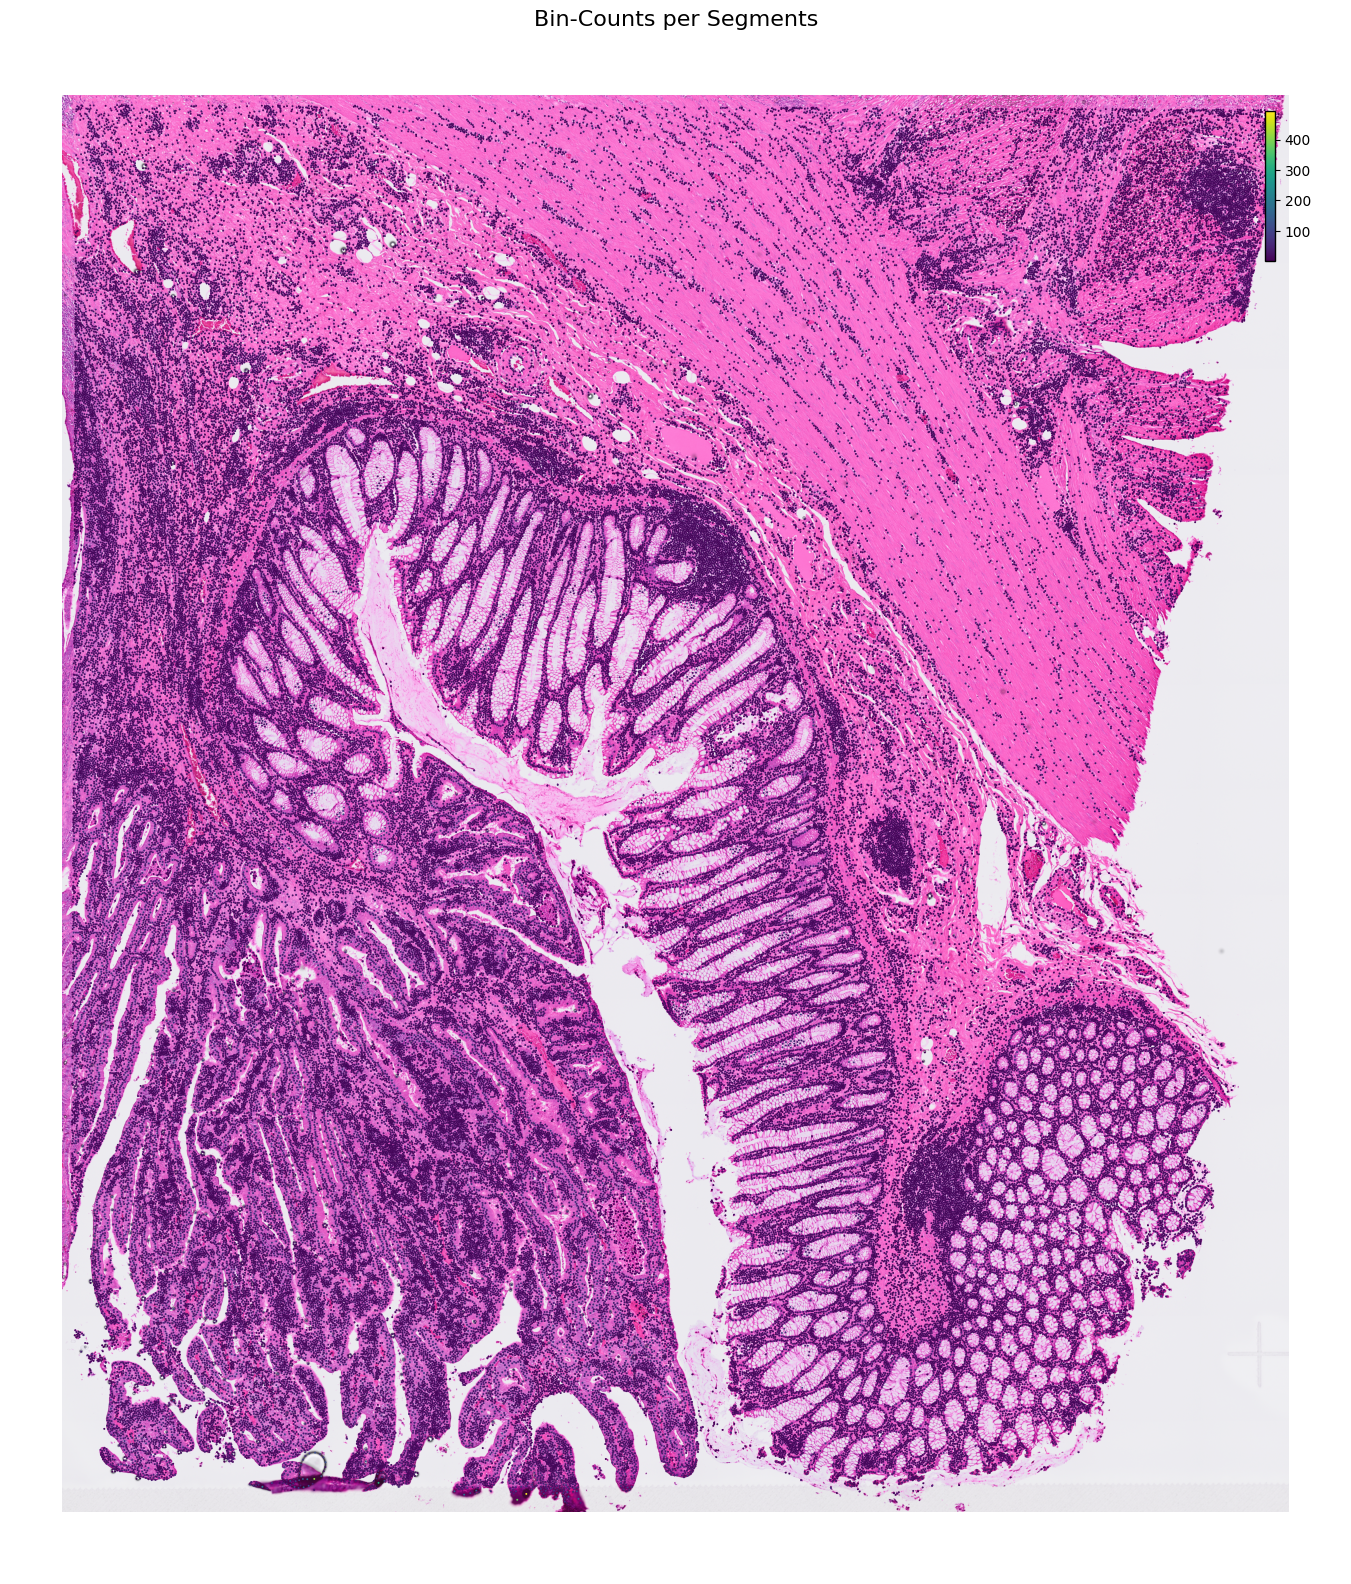

In [6]:
#adjust directories based on your own dataset, both GPU and CPU should work for segmentation. Apple Silicon is also compatible with the correct version.
cdata=run_bin2cell_segmentation(sample_id=sample_id,binned_002="../../sampleP5/binned_outputs/square_002um",
                                full_image="../../sampleP5/binned_outputs/Visium_HD_Human_Colon_Cancer_P5_tissue_image.btf",
                                spaceranger_image_path="../../sampleP5/binned_outputs/square_002um/spatial/",
                                device="cpu", #you may select GPU if available but CPU should be enough,
                                prob_thresh=0.2 #decrease to detect more cells, can take more time
                                )

In [ ]:
#some QC
cdata
mt_genes = cdata.var_names.str.startswith('MT-')
cdata = cdata[:, ~mt_genes]
sc.pp.filter_genes(cdata, min_cells=10)
sc.pp.filter_cells(cdata, min_counts=10)
cdata.raw = cdata.copy()
# Normalize and log transform
sc.pp.normalize_total(cdata, inplace=True, target_sum=1e4)
sc.pp.log1p(cdata)


_simple.py (287): Trying to modify attribute `.var` of view, initializing view as actual.


# Phase 1 - Detect expression hotspots for high level clusters
Read differential expression table for high level clusters.

In [11]:
#load the markers from a csv file
#"celltype" means grouping column, it is group for Scanpy, can be different for Seurat
#gene_id_column means gene ID column
#sort by scoring is a good idea.

pelka_top_level_markers_df=read_markers_dataframe(cdata,filename="../data/pelka_toplevel_deseq_table.csv",top_n_genes=60,sort_by_column="scores",celltype="group",gene_id_column="names")

pelka_top_level_markers_df.head()
#Note that this dataset contains programs which are not available in the target spatial dataset. If you have compatible dataset, it is better to use. However, this still works as intended. Only the genes available in both are kept.

Unique cell types detected in the dataframe:
['Epi' 'TNKILC' 'Plasma' 'Myeloid' 'B' 'Strom' 'Mast']


Unnamed: 0 group   names     scores  logfoldchanges  pvals  pvals_adj
group                                                                       
Epi          1518   Epi    KRT8  478.88394        7.256343    0.0        0.0
Epi          1520   Epi  LGALS4  463.74417        7.241442    0.0        0.0
Epi          1521   Epi   EPCAM  459.13583        7.299106    0.0        0.0
Epi          1522   Epi   PHGR1  454.80515        7.332155    0.0        0.0
Epi          1524   Epi  TSPAN8  437.13092        6.860310    0.0        0.0

In [12]:
#Now we will detect the main group hot spots.
#This is identical that we do for regular bins

df_cluster_sum_permutation=common_markers_gene_expression_and_filter(cdata,pelka_top_level_markers_df,filtering_algorithm="permutation",alpha=0.01,aggregation_method="sum",add_to_obs=True)


Subsample 25000/25000 for TNKILC: 100%|██████████| 1000/1000 [00:02<00:00, 336.94it/s]


Adding results to table.obs of sdata object


In [9]:
#You will see toplevel markers are added to cdata obs dataframe of your spatial object.
#You can directly use them for plotting.
cdata

AnnData object with n_obs × n_vars = 151295 × 18011
    obs: 'bin_count', 'array_row', 'array_col', 'B', 'Epi', 'Mast', 'Myeloid', 'Plasma', 'Strom', 'TNKILC'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial', 'spatial_cropped'

We visualize the expression hotspots for myeloid cells. We can use Scanpy spatial plotting functions rather than SpatialData.

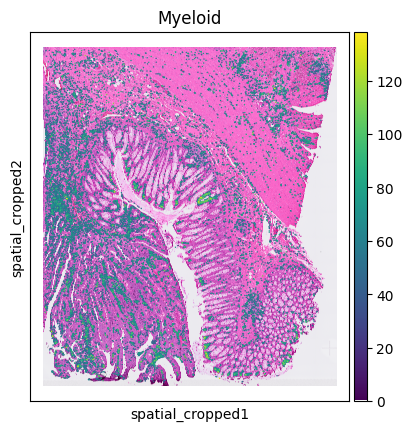

In [ ]:
#You may modify this to get more appealing plots.
sc.pl.spatial(
        cdata,
        color=["Myeloid"],
        img_key="0.5_mpp",
        basis="spatial_cropped",
        show=True,
        cmap=new_cmap,
        size=3) #we increased the size to make them more visible, default is 1


# Phase 2 - Load mid level clusters for myeloid cells

In [14]:
pelka_mid_level_myeloid_markers_df=read_markers_dataframe(cdata,filename="../data/pelka_midlevel_myeloid.csv",top_n_genes=60,sort_by_column="scores",celltype="group",gene_id_column="names")

#there are four cell types here

Unique cell types detected in the dataframe:
['Macro' 'Mono' 'DC' 'Granulo']


In [ ]:
#There is a column called Myeloid that , we transfer midlevel myeloid markers only these bins with enough expression
#This wont take too much time since we subset the large object

df_cluster_wjaccard=get_clusters_by_similarity_on_tissue(cdata,markers_df=pelka_mid_level_myeloid_markers_df,method="wjaccard",common_group_name="Myeloid")

Processing spots with Myeloid != 0
Number of threads used: 5
Batch size: 1000


100%|██████████| 19034/19034 [01:00<00:00, 314.88it/s]


Adding results to table.obs of sdata object


### Cell type assignment based on similarity

In [17]:
#We run weighted Jaccard similarity, we can directly visualize them or use them for assignment.
assign_clusters_from_df(cdata,df=df_cluster_wjaccard,bin_size=8,results_column=f"wjaccard_default")
#that is it, you will get a new column in the obs dataframe of your spatial object, called "wjaccard_default".

wjaccard_default
1                  NaN
10                 NaN
100                NaN
1000               NaN
10000               DC
...                ...
99995              NaN
99996              NaN
99997              NaN
99998              NaN
99999              NaN

[151178 rows x 1 columns]

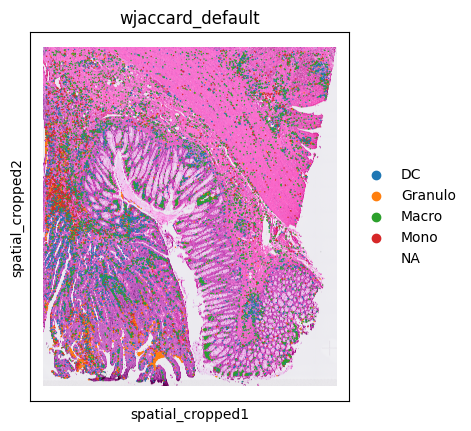

In [18]:
sc.pl.spatial(
        cdata,
        color=["wjaccard_default"],
        img_key="0.5_mpp",
        basis="spatial_cropped",
        show=True,
        size=3) #we increased the size to make them more visible, default is 1

# Phase 3 - Cell type proportion estimation

In [20]:
df_cluster_mye_proportions=get_proportions_on_tissue(cdata,markers_df=pelka_mid_level_myeloid_markers_df,method="nnls",common_group_name="Myeloid",normalization_method="zscore")

Processing spots with Myeloid != 0
Running deconvolution with parallel processing...
Normalization method: zscore
Number of threads used: 5
Running deconvolution with method='nnls', alpha=0.1...


100%|██████████| 19034/19034 [00:02<00:00, 8539.93it/s]


Adding results to table.obs of sdata object
Deconvolution completed.


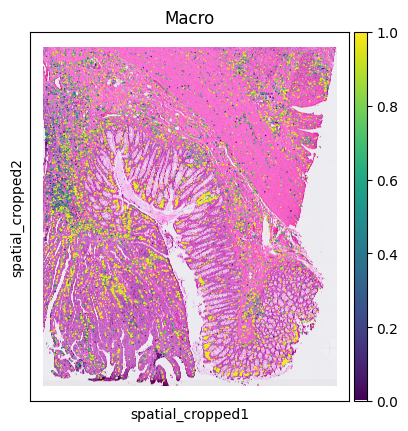

In [23]:
sc.pl.spatial(
        cdata,
        color=["Macro"],
        img_key="0.5_mpp",
        basis="spatial_cropped",
        show=True,
        cmap=new_cmap,
        size=3) #we increased the size to make them more visible, default is 1

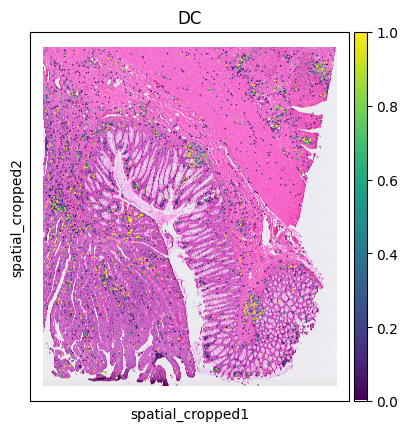

In [22]:
sc.pl.spatial(
        cdata,
        color=["DC"],
        img_key="0.5_mpp",
        basis="spatial_cropped",
        show=True,
        cmap=new_cmap,
        size=3) #we increased the size to make them more visible, default is 1